In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

import time
from multiprocessing import Pool
from tqdm.auto import tqdm
import re

import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt

import noctiluca as nl
import bayesmsd

In [2]:
import matplotlib as mpl
import matplotlib.colors as mplc

mpl.rcParams['figure.dpi'] = 300

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = "sans-serif"
# mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.size'] = 6

mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['ytick.major.pad'] = 1
mpl.rcParams['xtick.minor.size'] = 1
mpl.rcParams['xtick.minor.pad'] = 0.5
mpl.rcParams['ytick.minor.size'] = 1
mpl.rcParams['ytick.minor.pad'] = 0.5
mpl.rcParams['axes.labelpad'] = 1
mpl.rcParams['axes.titlepad'] = 3
mpl.rcParams['legend.handletextpad'] = 0.4
mpl.rcParams['legend.columnspacing'] = 1.0
mpl.rcParams['legend.frameon'] = False

mpl.rcParams['figure.subplot.top'] = 0.75
mpl.rcParams['figure.subplot.bottom'] = 0.25
mpl.rcParams['figure.subplot.left'] = 0.25
mpl.rcParams['figure.subplot.right'] = 0.75

In [3]:
colors = {
    'blue'    : '#0077BB',
    'cyan'    : '#33BBEE',
    'teal'    : '#009988',
    'orange'  : '#EE7733',
    'red'     : '#CC3311',
    'magenta' : '#EE3377',
    'grey'    : '#BBBBBB',
}

In [4]:
def ground_truth_msd(lagtime      = 1,    # sec
                     G            = 1e4,  # nm²/sec^α
                     a            = 0.3,  # 
                     motion_blur_f= 0,    # frames
                     sigma_err    = 0,    # nm
                     d            = 1,    # 
                    ):
    @bayesmsd.deco.MSDfun
    @bayesmsd.deco.imaging(noise2=sigma_err**2, f=motion_blur_f, alpha0=a)
    def msd(dt):
        return d*G*(dt*lagtime)**a
    return msd

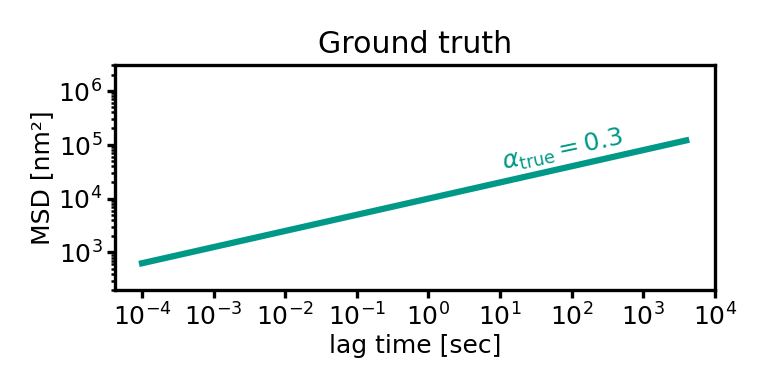

In [5]:
xplot = np.logspace(-4, 3.6, 100)
dt = xplot[0]
msd = ground_truth_msd(lagtime=dt)(xplot/dt)

fig = plt.figure(figsize=[4, 1.5])

plt.plot(xplot, msd, color=colors['teal'])

plt.xscale('log')
plt.yscale('log')
plt.xticks(np.logspace(-4, 4, 9))
plt.yticks(np.logspace(3, 6, 4))
plt.ylim([2e2, 3e6])
plt.xlabel('lag time [sec]')
plt.ylabel('MSD [nm²]')
plt.title('Ground truth')

plt.text(1e1, 8e4, r'$\alpha_\mathrm{true} = 0.3$',
         ha='left', va='center', rotation=12,
         color=colors['teal'],
        )

# plt.savefig('01_truth.pdf')
plt.show()

In [6]:
dt_T_f_s_d_N = [
    (1e-4, 2000,    1,  5, 2, 1),
    (1e-1,  200,    1, 10, 2, 2),
    (2,     200, 0.05, 100, 2, 2),
    (20,    200,    0, 100, 3, 2),
]

N_traj = 100

data = {}
for i, (dt, T, f, s, d, _) in enumerate(tqdm(dt_T_f_s_d_N)):
    data[i] = bayesmsd.gp.generate((ground_truth_msd(lagtime=dt, motion_blur_f=f, sigma_err=s, d=d), 1, d), T=T, n=N_traj)
    _ = nl.analysis.MSD(data[i])
    for traj in data[i]:
        traj.meta['Δt'] = dt

  0%|          | 0/4 [00:00<?, ?it/s]

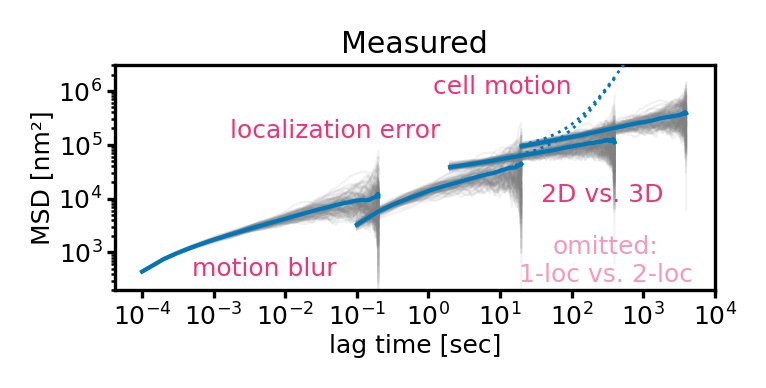

In [7]:
fig = plt.figure(figsize=[4, 1.5])
plt_kwargs = {
    'single trajectories' : dict(color='gray', linewidth=0.5, alpha=0.1),
    'ensemble MSDs'       : dict(color=colors['blue'], linewidth=1, zorder=10),
    'terms'               : dict(color=colors['magenta'], zorder=20),
}

for i in data:
    dt, T, f, s, d, N = dt_T_f_s_d_N[i]
    
    for traj in data[i]:
        msd = nl.analysis.MSD(traj)
        plt.plot(dt*np.arange(1, len(msd)), msd[1:], **plt_kwargs['single trajectories'])

    msd = nl.analysis.MSD(data[i])
    xplot = dt*np.arange(1, len(msd))
    plt.plot(xplot, msd[1:], **plt_kwargs['ensemble MSDs'])
    if N > 1:
        kwargs = {key : val for key, val in plt_kwargs['ensemble MSDs'].items()}
        kwargs['linestyle'] = ':'
        kwargs['linewidth'] = 0.7
        plt.plot(xplot, msd[1:]+1e1*xplot**2, **kwargs)


plt.xscale('log')
plt.yscale('log')
plt.xticks(np.logspace(-4, 4, 9))
plt.yticks(np.logspace(3, 6, 4))
plt.ylim([2e2, 3e6])
plt.xlabel('lag time [sec]')
plt.ylabel('MSD [nm²]')
plt.title('Measured')

plt.text(5e-4, 3e2, 'motion blur',
         ha='left', va='bottom', **plt_kwargs['terms'],
        )
plt.text(5e-2, 3e5, 'localization error',
         ha='center', va='top', **plt_kwargs['terms'],
        )
plt.text(1e2, 2e6, 'cell motion',
         ha='right', va='top', **plt_kwargs['terms'],
        )
plt.text(2.7e2, 2e4, '2D vs. 3D',
         ha='center', va='top', **plt_kwargs['terms'],
        )
plt.text(3e2, 2.3e2, 'omitted:\n1-loc vs. 2-loc',
         ha='center', va='bottom', **plt_kwargs['terms'], alpha=0.5,
        )

# plt.savefig('01_measured.pdf')
plt.show()

In [8]:
fits = {}
for i in data:
    dt, T, f, s, d, N = dt_T_f_s_d_N[i]
    fit = bayesmsd.lib.NPFit(data[i], motion_blur_f=data[i][0].meta['Δt']*f)
    for d in range(1, fit.d):
        fit.parameters[f'log(σ²) (dim {d})'].fix_to = 'log(σ²) (dim 0)'
    fit.likelihood_chunksize = 1

    fits[str(i)] = fit

fit = bayesmsd.FitGroup(fits)
for i in range(1, len(fits)):
    fit.parameters[f'{i} log(Γ) (dim 0)'].fix_to = '0 log(Γ) (dim 0)'
    fit.parameters[f'{i} α (dim 0)'     ].fix_to = '0 α (dim 0)'
fit.parameters[    '3 log(σ²) (dim 0)'  ].fix_to = '2 log(σ²) (dim 0)'
# fit.likelihood_chunksize = 1

with nl.Parallelize():
    res = fit.run(show_progress=True)

fit iterations: 0it [00:00, ?it/s]

In [9]:
# nl.io.write.hdf5({
#     'data' : {str(key) : data[key] for key in data},
#     'NP_fitres' : res,
#     'description' : """
# Synthetic data sets and joint NP fit result; for cartoons in Fig. 3 of MINFLUX paper
# 
# Data are generated with
# 
# dt_T_f_s_d_N = [
#     (1e-4, 2000,    1,   5, 2, 1),
#     (1e-1,  200,    1,  10, 2, 2),
#     (2,     200, 0.05, 100, 2, 2),
#     (20,    200,    0, 100, 3, 2),
# ]
# 
# G = 1e4, a = 0.3
# """[1:-1]}, '20250415_synthetic_data_and_fitres.h5')

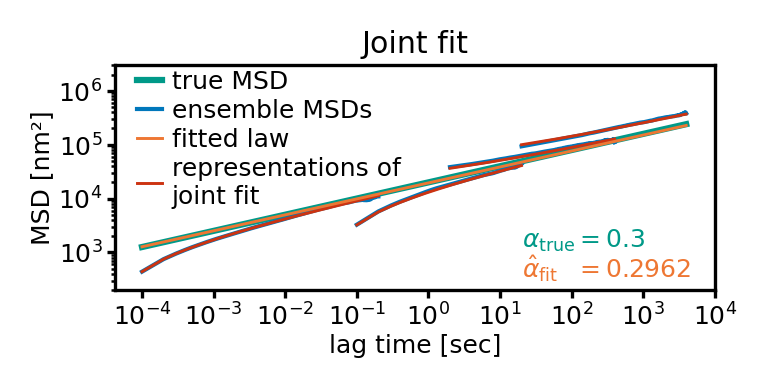

In [10]:
fig = plt.figure(figsize=[4, 1.5])
plt_kwargs = {
    'truth'               : dict(color=colors['teal']),
    'single trajectories' : dict(color='gray', linewidth=0.5, alpha=0.1),
    'ensemble MSDs'       : dict(color=colors['blue'], linewidth=1, zorder=10),
    'terms'               : dict(color=colors['teal'], zorder=20),
    'fits'                : dict(color=colors['red'], linewidth=0.7, zorder=30, linestyle='-'),
    'fits_law'            : dict(color=colors['orange'], linewidth=0.7, zorder=30, linestyle='-'),
}

for i in data:
    dt, T, f, s, d, N = dt_T_f_s_d_N[i]

    msd = nl.analysis.MSD(data[i])
    xplot = dt*np.arange(1, len(msd))
    plt.plot(xplot, msd[1:], **plt_kwargs['ensemble MSDs'])

    params = {key[2:] : val for key, val in res['params'].items() if key.startswith(str(i))}
    params = fits[str(i)].fill_dependent_params(params)
    msd = fits[str(i)].MSD(params, xplot)
    plt.plot(xplot, msd, **plt_kwargs['fits'])

xplot = np.logspace(-4, 3.6, 100)
dt = xplot[0]
msd = ground_truth_msd(lagtime=dt, d=2)(xplot/dt)
plt.plot(xplot, msd, **plt_kwargs['truth'])

msd = ground_truth_msd(lagtime=dt, G=2*np.exp(res['params']['0 log(Γ) (dim 0)']), a=res['params']['0 α (dim 0)'])(xplot/dt)
plt.plot(xplot, msd, **plt_kwargs['fits_law'])

plt.plot(0, 0, **plt_kwargs['truth'], label='true MSD')
plt.plot(0, 0, **plt_kwargs['ensemble MSDs'], label='ensemble MSDs')
plt.plot(0, 0, **plt_kwargs['fits_law'], label='fitted law')
plt.plot(0, 0, **plt_kwargs['fits'], label='representations of\njoint fit')
plt.legend(loc=(0.02, 0.32), handlelength=1, labelspacing=0.2)

plt.text(2e1, 1.7e3, r'$\alpha_\mathrm{true} = 0.3$',
         ha='left', va='center', color=plt_kwargs['truth']['color'],
        )
plt.text(2e1, 5e2, r"$\hat\alpha_\mathrm{fit}\;\;\, = "+f"{res['params']['0 α (dim 0)']:.4f}$",
         ha='left', va='center', color=plt_kwargs['fits_law']['color'],
)

plt.xscale('log')
plt.yscale('log')
plt.xticks(np.logspace(-4, 4, 9))
plt.yticks(np.logspace(3, 6, 4))
plt.ylim([2e2, 3e6])
plt.xlabel('lag time [sec]')
plt.ylabel('MSD [nm²]')
plt.title('Joint fit')

# plt.savefig('01_fit.pdf')
plt.show()